# Compute a dataframe containing all behavior for each subject

* How it works
    #finger0_deriv = np.abs(np.diff(finger0))
    #thresh = 50
    #is_moving_finger0 = finger0_deriv > thresh
    #move_samples_finger0 = np.argwhere(is_moving==1).transpose()[0]
    #move_samples_diff_finger0 = np.diff(move_samples_finger0)

# Imports

In [1]:
from __future__ import print_function
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd

# Useful functions

In [2]:
# Find start and end times of movement
def fingerStartEnd (finger, thresh = 50, time_thresh = 1000):
    all_start_samps = []
    all_end_samps = []

    finger_deriv = np.abs(np.diff(finger))
    is_moving = finger_deriv > thresh
    move_samples = np.argwhere(is_moving==1).transpose()[0]
    move_samples_diff = np.diff(move_samples)

    all_start_samps.append(move_samples[0])

    N_samps = len(move_samples)
    for i in range(1,N_samps):
        if move_samples_diff[i-1] > time_thresh:
            all_start_samps.append(move_samples[i])
            all_end_samps.append(move_samples[i-1])
    all_end_samps.append(move_samples[-1])
    return np.array(all_start_samps), np.array(all_end_samps)

In [3]:
# Delete movements unrelated to local cue
def deleteStartEnd(fingers,interval):
    for k in range(5):
        for i, j in zip(fingers['start'][k],fingers['end'][k]):
            if (j-i<interval):
                fingers['start'][k].remove(i)
                fingers['end'][k].remove(j)

# Load data

In [44]:
subj_name = 2
data_dir = 'C:/data2/dg'
subjects = glob.glob(data_dir+'/*')
all_subjects = []
all_subj_fingers={}
all_cues={}
all_cues_diff={}

plot = False

# Get all subject files
for sub in subjects:
    # Get 
    if len(sub) == len(data_dir)+1+subj_name:
        file_name = sub[-subj_name:]
        all_subjects.append(file_name)

# Load cue for each subject and find start/stop times
for subjcode in all_subjects:
    
    cue = np.load(data_dir+'/'+subjcode+'/cue.npy')
    all_cues_diff[subjcode]=np.diff(cue)
    
    # Compute finger start and stop times
    all_subj_fingers[subjcode]={'start':{},'end':{}}
    raw_finger=[]
    for i in range(5):
        finger = np.load(data_dir+'/'+subjcode+'/finger'+str(i)+'.npy')
        raw_finger.append(finger)
        
        all_subj_fingers[subjcode]['start'][i],all_subj_fingers[subjcode]['end'][i]=fingerStartEnd(finger)
    
    if plot:
        all_cues[subjcode]={'start':{},'end':{}}
        for index in range(5):
            all_cues[subjcode]['start'][index] = np.where(xx==index+1)[0]
            all_cues[subjcode]['end'][index] = np.where(xx==-index-1)[0]

        plt.figure(figsize=(16,8))

        f, sub = plt.subplots(5, sharex=True,figsize=(16,8))
        for k in range(5):
            sub[k].plot(raw_finger[k])

            for start,end in zip(all_subj_fingers[subjcode]['start'][k],all_subj_fingers[subjcode]['end'][k]):
                sub[k].axvline(x=start, ymin=0, ymax = 3000, linewidth=2, color='k')
                sub[k].axvline(x=end, ymin=0, ymax = 3000, linewidth=2, color='r', alpha=0.5)
            for cueS, cueE in zip(all_cues[subjcode]['start'][k],all_cues[subjcode]['end'][k]):
                sub[k].axvline(x=cueS, ymin=0, ymax = 3000, linewidth=2, color='g')
                sub[k].axvline(x=cueE, ymin=0, ymax = 3000, linewidth=2, color='y')
            plt.xlim(0,50000)


['bp', 'cc', 'ht', 'jc', 'jp', 'wc', 'wm', 'zt']


# Structure behavioral data into Pandas dataframe

* Loop through each cue_start (each trial)
* For each cue_start also find:
    * cue_end
    * finger
    * move start
    * move end
    * delay start
    * delay end
    * duration move
    
each column as a key in a dictionary

In [5]:
def generateDataFrame(cue_diff,fingers, subj):
    data_frame={}

    #Find cue start and end for each trial
    data_frame['cue_start']=np.where(cue_diff>0)[0]
    data_frame['cue_end']=np.where(cue_diff<0)[0]
    
    if subj == 'jp':
        data_frame['cue_end'] = np.delete(data_frame['cue_end'],0)
    elif subj == 'wm':
        data_frame['cue_start'] = np.delete(data_frame['cue_start'],-1)

    #Find corresponding fingers for each trial
    data_frame['finger'] = np.array(cue_diff[data_frame['cue_start']])
    
    data_frame['move_start'] = []
    data_frame['move_end'] = []
    for i in data_frame['cue_start']:
        if sum(fingers['start'][cue_diff[i]-1]>i) >= 1:
            data_frame['move_start'].append(fingers['start'][cue_diff[i]-1][fingers['start'][cue_diff[i]-1]>i][0])
        else:
            data_frame['move_start'].append(np.nan)
    for i in data_frame['cue_end']:
        if sum(fingers['end'][abs(cue_diff[i])-1]>i) >= 1:
            data_frame['move_end'].append(fingers['end'][abs(cue_diff[i])-1][fingers['end'][abs(cue_diff[i])-1]>i][0])
        else:
            data_frame['move_end'].append(np.nan)
    data_frame['move_start'] =  np.array(data_frame['move_start'])
    data_frame['move_end'] = np.array(data_frame['move_end'])    
    data_frame['delay_start']=data_frame['move_start']-data_frame['cue_start']
    data_frame['delay_end']=data_frame['move_end']-data_frame['cue_end']
    data_frame['duration']=data_frame['move_end']-data_frame['move_start']
    return data_frame

In [12]:
dfs = []
data_frame_all=[]
for i in all_cues_diff.keys():
    data_frame=generateDataFrame(all_cues_diff[i],all_subj_fingers[i], i)
    dfs.append(pd.DataFrame.from_dict(data_frame))
    data_frame_all.append(data_frame)
    dfs[-1]['subject'] = i
print(data_frame_all)

[{'cue_start': array([  7079,  11079,  15079,  19079,  23079,  27079,  31079,  35079,
        39079,  43079,  47079,  51079,  55079,  59079,  63079,  67079,
        71079,  75079,  79079,  83079,  87079,  91079,  95079,  99079,
       103079, 107079, 111079, 115079, 119079, 123079, 127079, 131079,
       135079, 139079, 143079, 147079, 151079, 155079, 159079, 163079,
       167079, 171079, 175079, 179079, 183079, 187079, 191079, 195079,
       199079, 203079, 207079, 211079, 215079, 219079, 223079, 227079,
       231079, 235079, 239079, 243079, 247079, 251079, 255079, 259079,
       263079, 267079, 271079, 275079, 279079, 283079, 287079, 291079,
       295079, 299079, 303079, 307079, 311079, 315079, 319079, 323079,
       327079, 331079, 335079, 339079, 343079, 347079, 351079, 355079,
       359079, 363079, 367079, 371079, 375079, 379079, 383079, 387079,
       391079, 395079, 399079, 403079, 407079, 411079, 415079, 419079,
       423079, 427079, 431079, 435079, 439079, 443079, 447079,

In [50]:
df = pd.concat(dfs)
df = df.reset_index(drop=True)
df.to_csv('./behavior_all.csv')
df


,cue_end,cue_start,delay_end,delay_start,duration,finger,move_end,move_start,subject
0,9079,7079,680.0,1160.0,1520.0,5.0,9759.0,8239.0,bp
1,13079,11079,640.0,840.0,1800.0,5.0,13719.0,11919.0,bp
2,17079,15079,400.0,720.0,1680.0,5.0,17479.0,15799.0,bp
3,21079,19079,600.0,800.0,1800.0,1.0,21679.0,19879.0,bp
4,25079,23079,560.0,880.0,1680.0,5.0,25639.0,23959.0,bp
5,29079,27079,240.0,1160.0,1080.0,2.0,29319.0,28239.0,bp
6,33079,31079,840.0,1440.0,1400.0,3.0,33919.0,32519.0,bp
7,37079,35079,80.0,640.0,1440.0,4.0,37159.0,35719.0,bp
8,41079,39079,760.0,1000.0,1760.0,1.0,41839.0,40079.0,bp
9,45079,43079,760.0,1040.0,1720.0,1.0,45839.0,44119.0,bp


# Plot histograms of finger delays

['bp', 'cc', 'ht', 'jc', 'jp', 'wc', 'wm', 'zt']
0
1
2
3
4
5
6
7


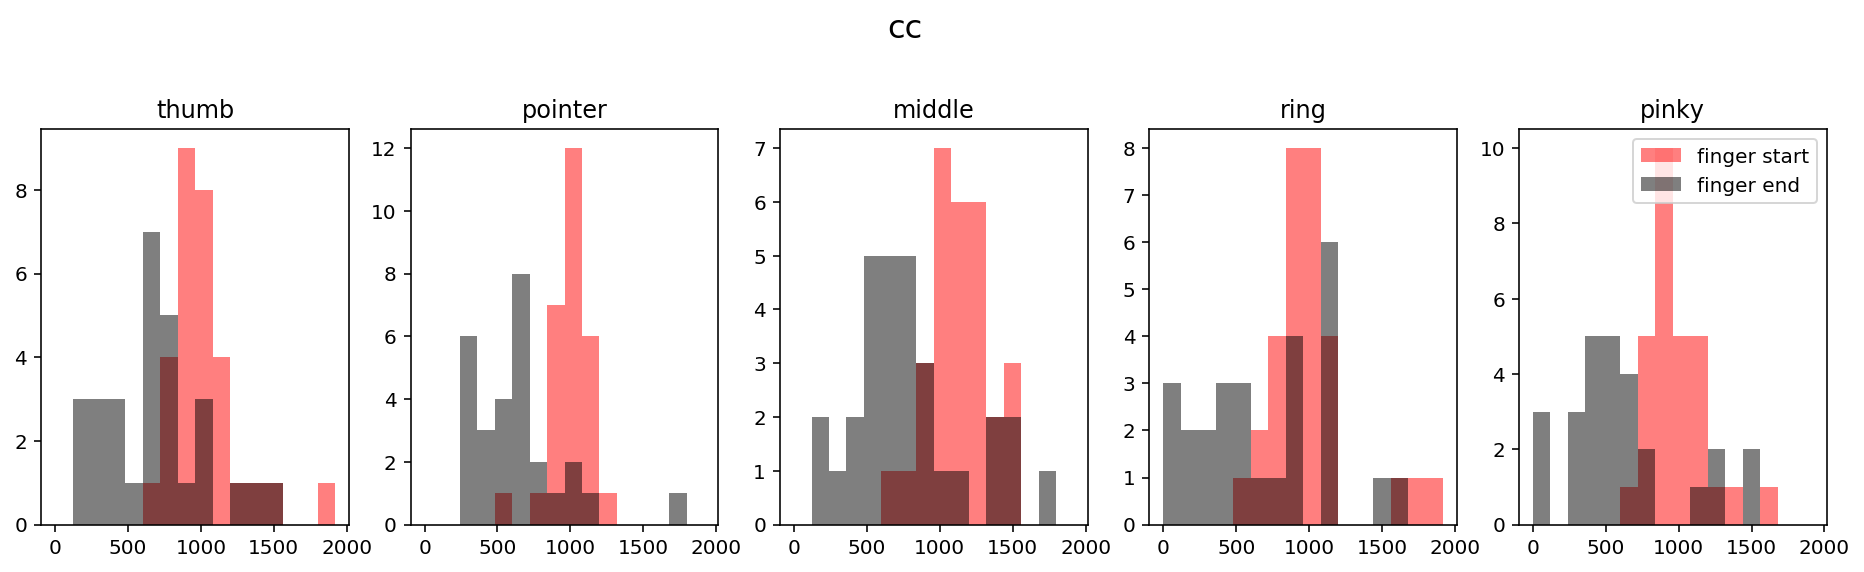

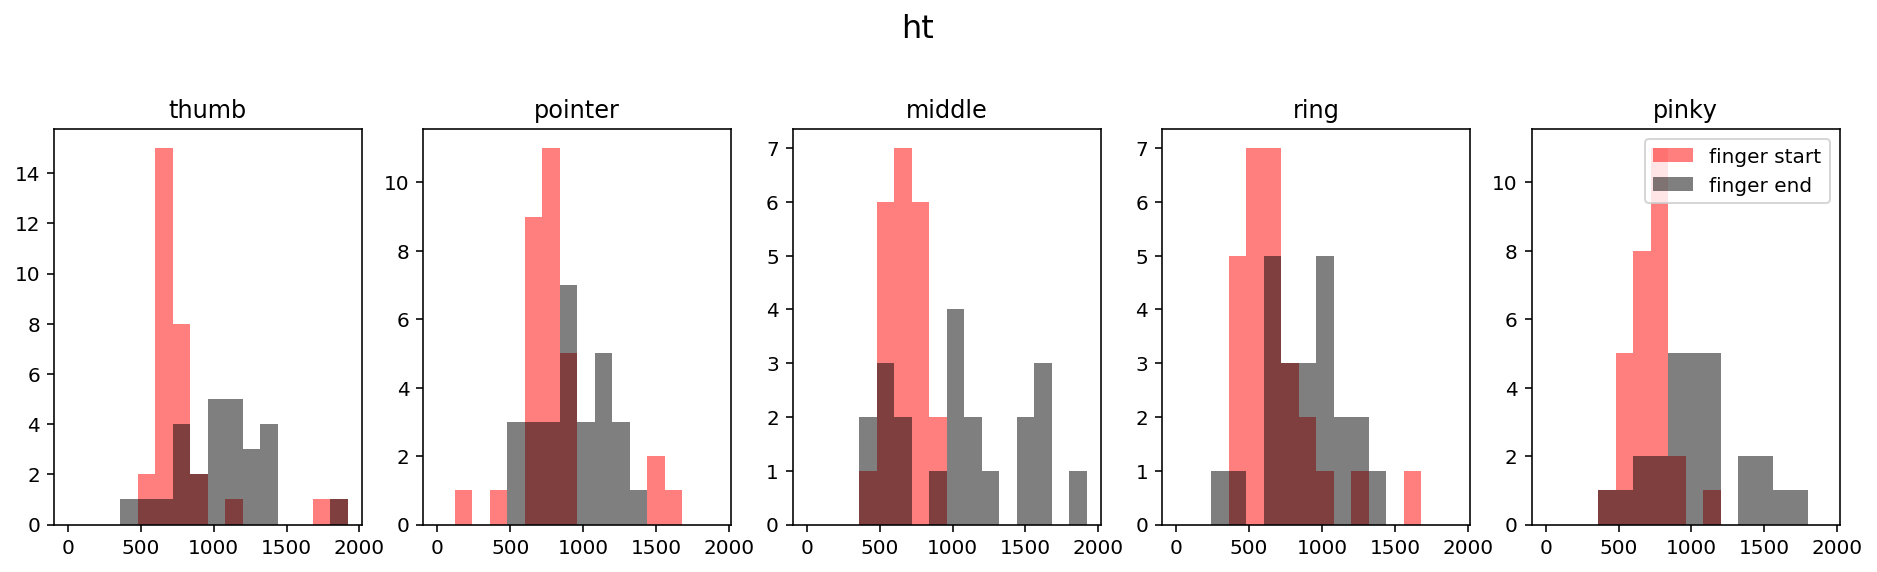

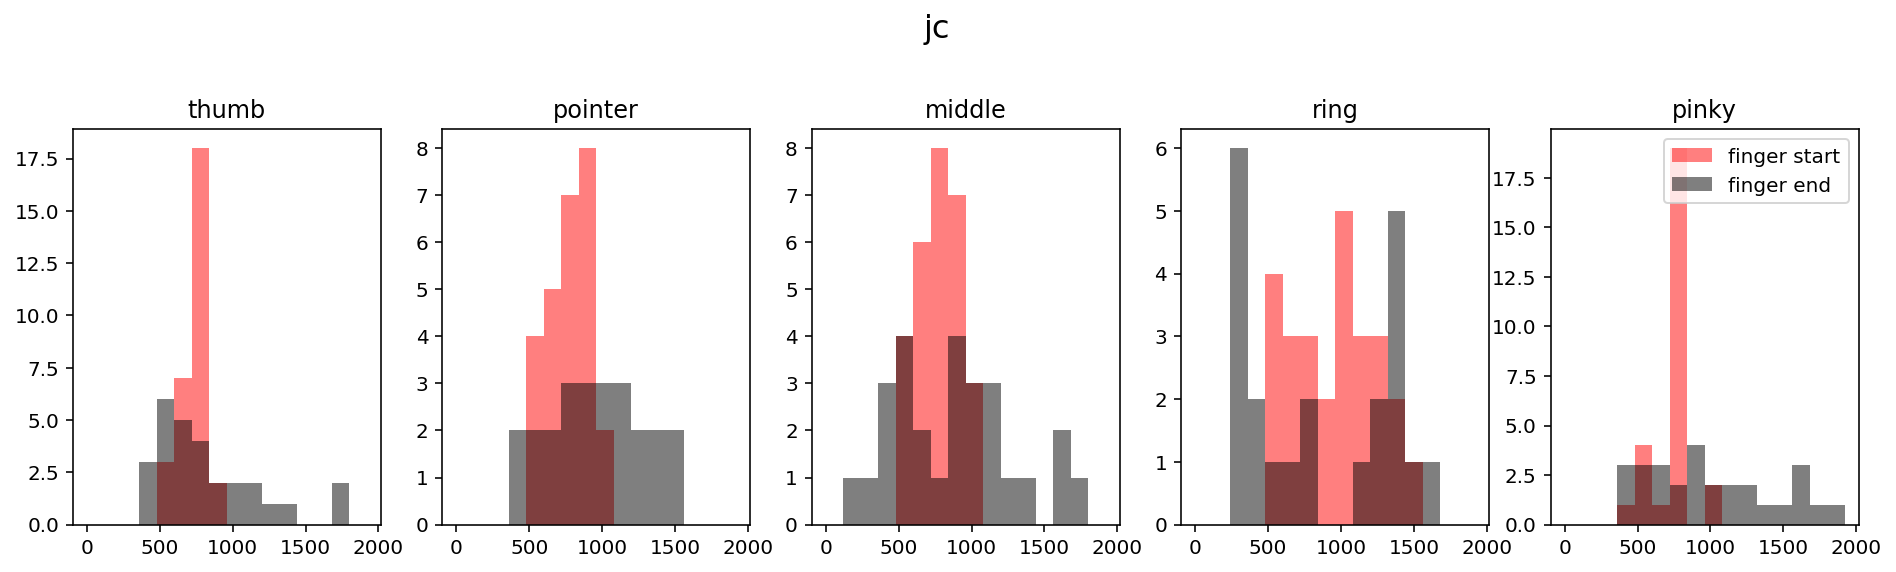

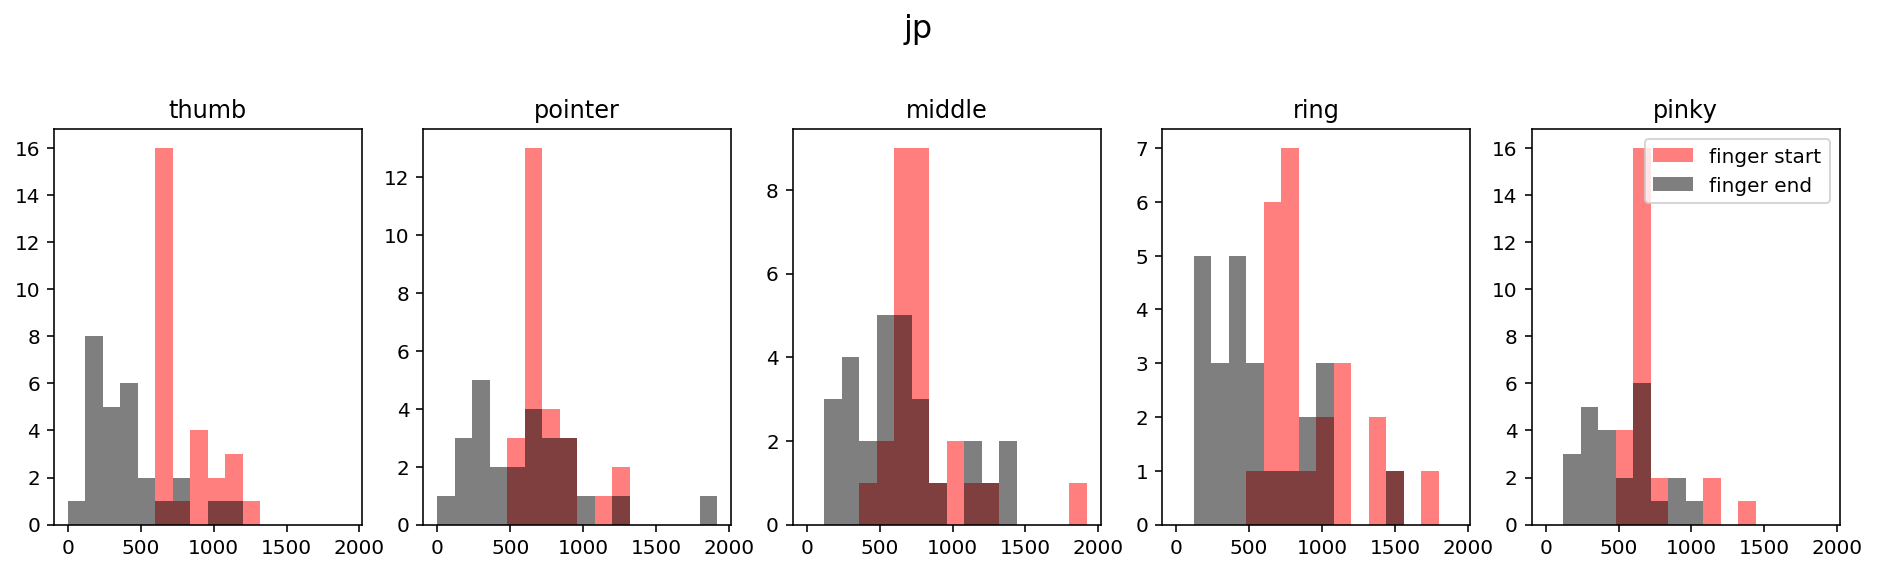

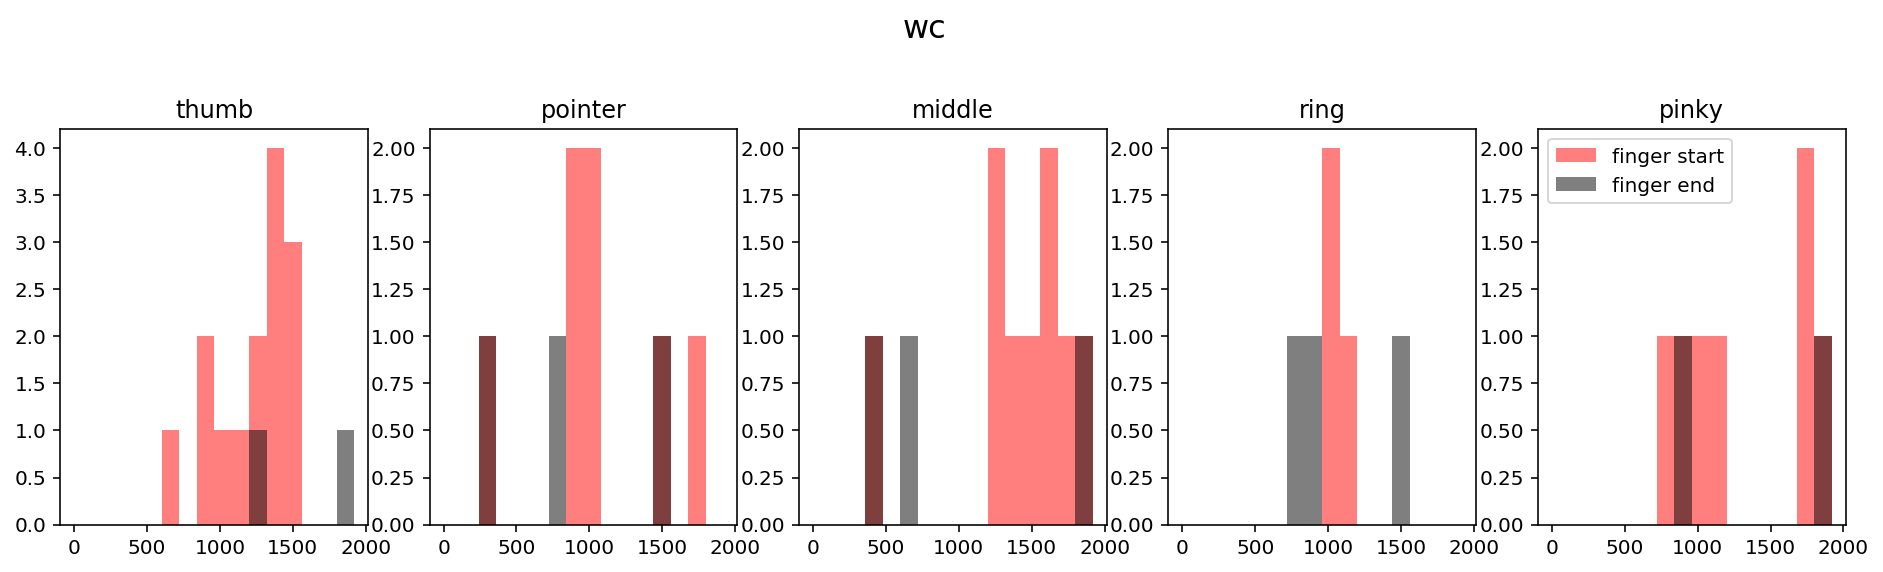

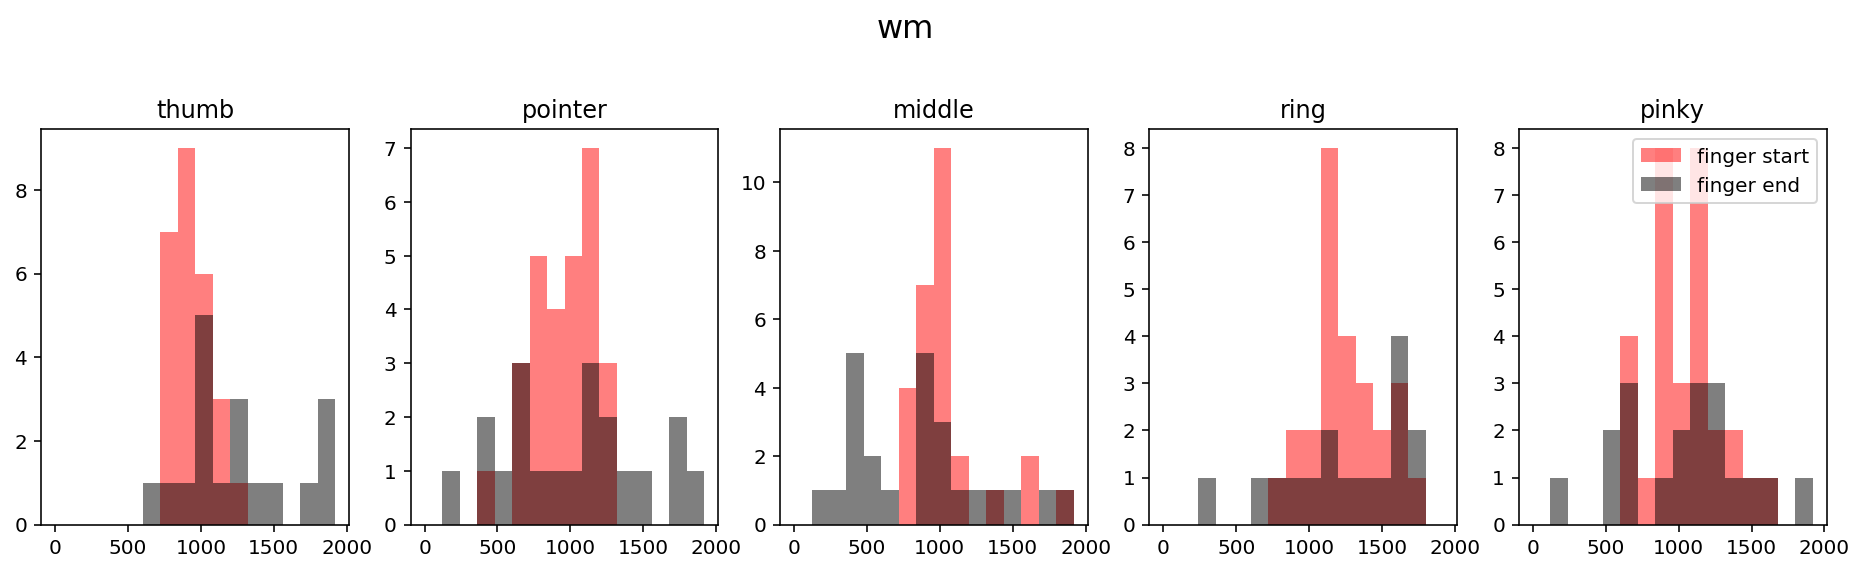

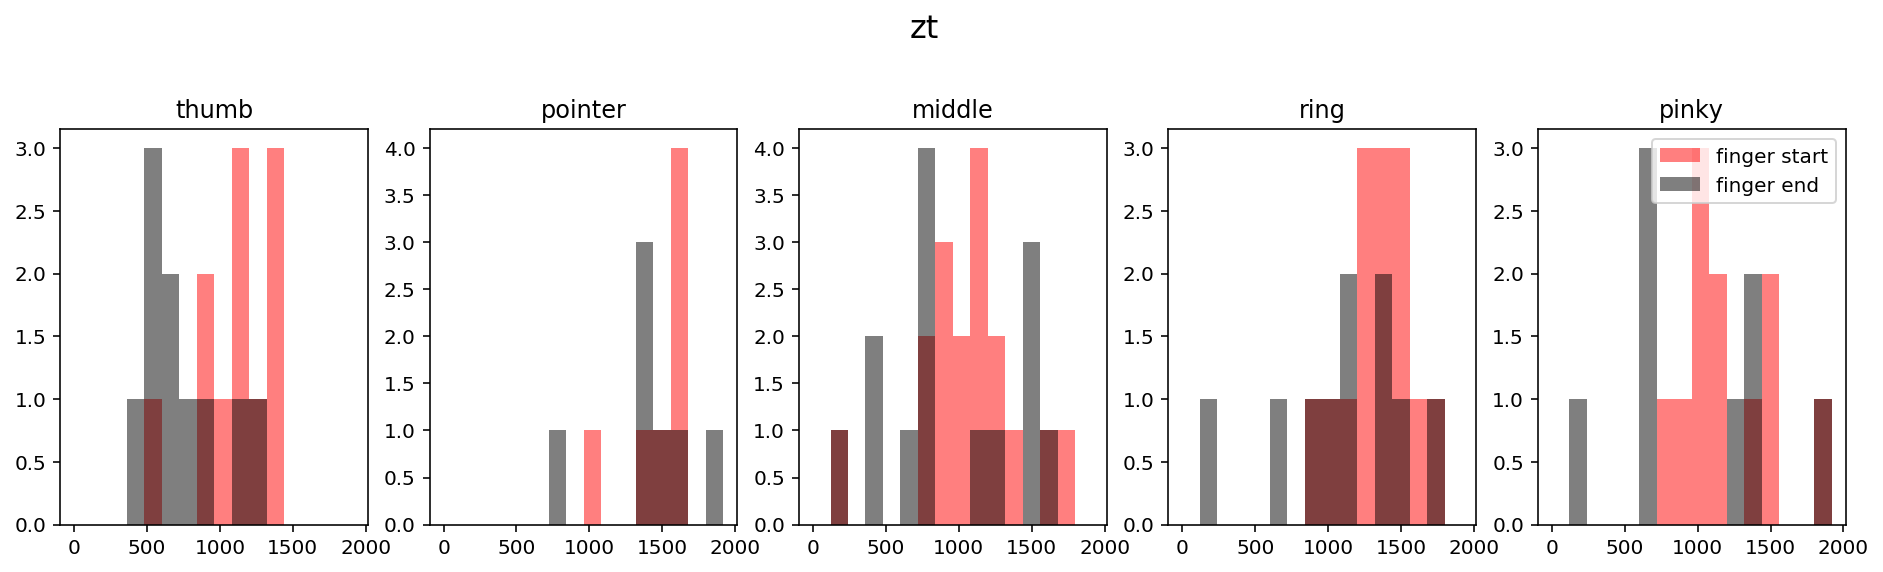

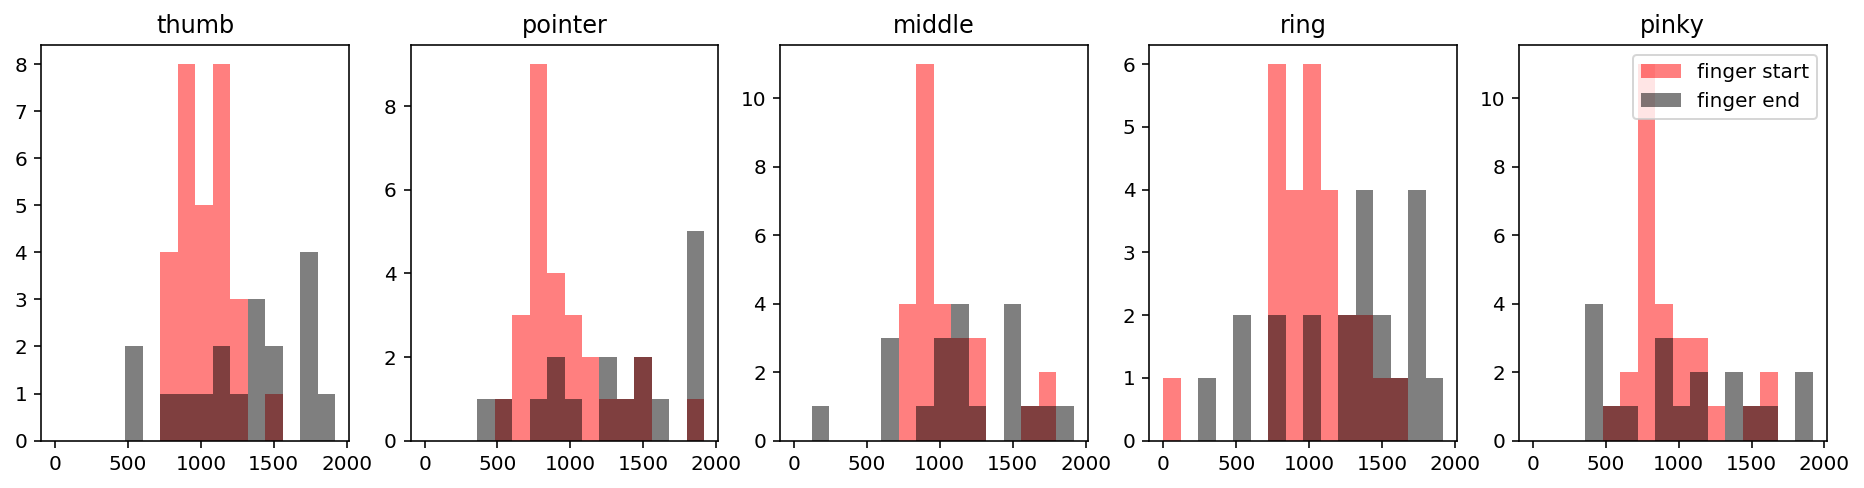

In [52]:
plt.figure(figsize=(16,8))


finger_names = ['thumb','pointer','middle','ring','pinky']

colorArr=['r','k','b','g','y']

print(all_subjects)
for j in range(len(data_frame_all)):
    fig=plt.figure(j+1)
    print(j)
    fig.suptitle(all_subjects[j], fontsize=16)
    plt.figure(figsize=(16,8))
    for i in range(5):
        plt.subplot(2,5,i+1)
        plt.title(finger_names[i])
        A=dfs[j].query('finger=='+str(i+1))['delay_start']
        B=dfs[j].query('finger=='+str(i+1))['delay_end']
        plt.hist(A[~np.isnan(A)],bins=np.arange(0,2000,120),color='r',alpha=.5,label='finger start')
        plt.hist(B[~np.isnan(B)],bins=np.arange(0,2000,120),color='k', alpha=.5,label='finger end')
    plt.legend(loc='best')

     cue_end  cue_start  delay_end  delay_start  duration  finger  move_end  \
3      21079      19079        600          800      1800     1.0     21679   
8      41079      39079        760         1000      1760     1.0     41839   
9      45079      43079        760         1040      1720     1.0     45839   
10     49079      47079        960         1120      1840     1.0     50039   
21     93079      91079        520          840      1680     1.0     93599   
24    105079     103079        600          880      1720     1.0    105679   
26    113079     111079       1000         1120      1880     1.0    114079   
29    125079     123079        840          920      1920     1.0    125919   
42    177079     175079        720         1040      1680     1.0    177799   
50    209079     207079        640         1000      1640     1.0    209719   
51    213079     211079        800          840      1960     1.0    213879   
59    245079     243079        640          880     

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C1E6BDF550>]], dtype=object)

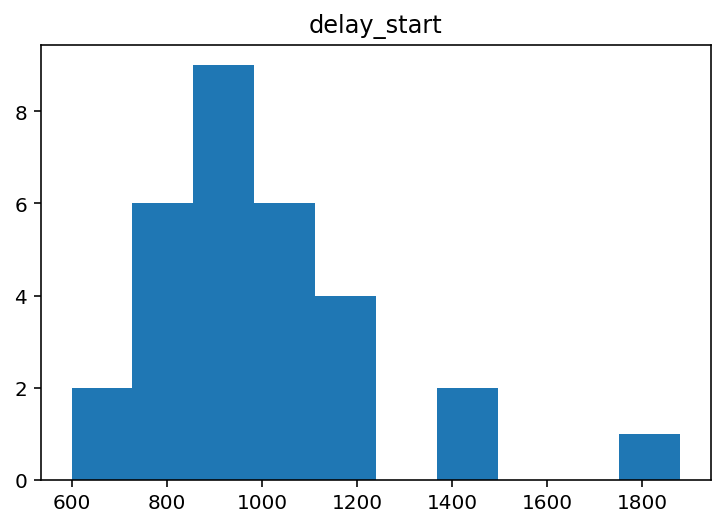

In [37]:
x=dfs[0].query('finger==1')
print(x)
pd.DataFrame.hist(x,column='delay_start',grid=False)